# Semi Final Codes Notebook

## Intro

The purpose of this notebook is to keep the necessary blocks and codes that we are going to use in our final model.
It will help us to keep track of every finished part of the project and helps with debugging of each section as we are ready to implement them.  

## General Initialization and Importing Libraries

In [4]:
# Libraries to install

# %pip install librosa
# %pip install matplotlib==3.3.4
# %pip install datasets[audio]

In [55]:
import os, sys
import pickle

import numpy as np
import pandas as pd

import torch
torch.manual_seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import librosa

import Lib  # the project's own library of functions

In [61]:
# Keep track of resources
# import wandb
# wandb.init(project='MAIS - Emotion Classifier')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Initializing Datasets

Note: Make sure you have downloaded the datasets and placed them in the './Data/' directory

each of these blocks pre-process their respective dataset. For each available dataset, run it's corresponding block to make sure its ready to be utilized.

In [8]:
CREMA = Lib.CREMA()

Dataset has already been normalized and resampled. Skipping...


In [9]:
RAVDESS = Lib.RAVDESS()

Dataset has already been normalized and resampled. Skipping...


In [10]:
SAVEE = Lib.SAVEE()

Dataset has already been normalized and resampled. Skipping...


In [11]:
TESS = Lib.TESS()

Dataset has already been normalized and resampled. Skipping...


## Preparing the Data

In [12]:
def pad_audio(audio, sr, desired_length_in_sec):

    # desired_length is desired length of audio in seconds
    # audio is the raw audio signal as numpy array from librosa
    # sr is sampling rate
    desired_length = int(sr * desired_length_in_sec)

    # Truncate if too long
    if len(audio) > desired_length:
        audio = audio[:desired_length]
        # TODO: Check for silent parts before cropping the audio file

    # Else, pad with 0s
    else:
        padding = int(desired_length - len(audio))
        audio = np.pad(audio, (0, padding), 'constant')
    return audio

In [13]:
# extract MFCCs from the audio files
def extract_mfccs(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    audio = pad_audio(audio, sr, 2.0)

    # This returns an mfcc where the COLUMNS correspond to the frames of the audio,
    # and ROWS represent features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # This extracts info about the first and second derivative of the mfcc
    # so we can get an idea of how the audio changes over time
    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Stacking mfcc and deltas together
    combined_matrix = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    # print("MFCC shape:", mfcc.shape)
    # print("Delta MFCC shape:", delta_mfcc.shape)
    # print("Delta2 MFCC shape:", delta2_mfcc.shape)

    # Normalize mfccs
    combined_matrix = (combined_matrix - np.mean(combined_matrix, axis=0)) / np.std(combined_matrix, axis=0)
    # print("Combined matrix shape before transpose:", combined_matrix.shape)

    # We transpose so that the ROWS correspond to the frames of the audio, 
    # while COLUMNS represent features
    transposed_matrix = np.transpose(combined_matrix, [1, 0])
    # print("Transposed matrix shape:", transposed_matrix.shape)

    return transposed_matrix

In [14]:
def display_mfcc(mfcc_matrix):
    # Display the combined matrix
    combined_matrix = np.transpose(mfcc_matrix, [1, 0])
    plt.figure(figsize=(12, 6))
    plt.imshow(combined_matrix, aspect='auto', origin='lower', cmap='viridis')

    # We divide the y-axis into three equal parts to denote MFCC, delta, and delta-delta regions
    num_rows = combined_matrix.shape[0]
    plt.yticks(
        [num_rows/6, num_rows/2, 5*num_rows/6],
        ['MFCC', 'Delta', 'Delta-Delta']
    )

    plt.title('Combined MFCC, Delta, Delta-Delta Coefficients')
    plt.xlabel('Frame')
    plt.ylabel('Coefficients')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [15]:
class ResampledAudioDataset(Dataset):
    
    def __init__(self, *datasets):
        # 'audio_files' is a dictionary that will contain path and labels for every audio file in the given datasets
        # and is formatted as {'path': [], 'label': []}
        self.audio_files = Lib.merge_dataset_dictionaries(*datasets)
        print(pd.DataFrame(self.audio_files))

    def __len__(self):
        return len(self.audio_files['path'])
    
    def num_classes(self):
        return len(set(self.audio_files['label']))
    
    def __getitem__(self, index):
        audio_path = self.audio_files['path'][index]
        audio_label = self.audio_files['label'][index]
        audio_file = extract_mfccs(audio_path)

        # Prints the the requested audio file details
        # It has been commented to reduce clutter during debug
        '''
        print('----------- Audio file Data -----------')
        print('Audio path:', audio_path)
        print ('Audio label:', audio_label, f'({Lib.convert_label(audio_label)})')
        '''
        return audio_file, audio_label

In [16]:
# creating the dataset from all available audio files for the model
audio_dataset = ResampledAudioDataset(CREMA, TESS, SAVEE, RAVDESS)

train_len = int(len(audio_dataset) * 0.8)   # 80% of the data will be used for the training
test_len = len(audio_dataset) - train_len   # 20% of the data will be used for the testing
train_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [train_len, test_len])

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

                                                    path  label
0      Data\resampled\CREMA\CREMA_resampled_0_emotion...      4
1      Data\resampled\CREMA\CREMA_resampled_1_emotion...      6
2      Data\resampled\CREMA\CREMA_resampled_2_emotion...      5
3      Data\resampled\CREMA\CREMA_resampled_3_emotion...      2
4      Data\resampled\CREMA\CREMA_resampled_4_emotion...      0
...                                                  ...    ...
12157  Data\resampled\RAVDESS\RAVDESS_resampled_1435_...      7
12158  Data\resampled\RAVDESS\RAVDESS_resampled_1436_...      7
12159  Data\resampled\RAVDESS\RAVDESS_resampled_1437_...      7
12160  Data\resampled\RAVDESS\RAVDESS_resampled_1438_...      7
12161  Data\resampled\RAVDESS\RAVDESS_resampled_1439_...      7

[12162 rows x 2 columns]


### ----------------- Temp Test Block -----------------

In [17]:
audio_dataset.num_classes()

8

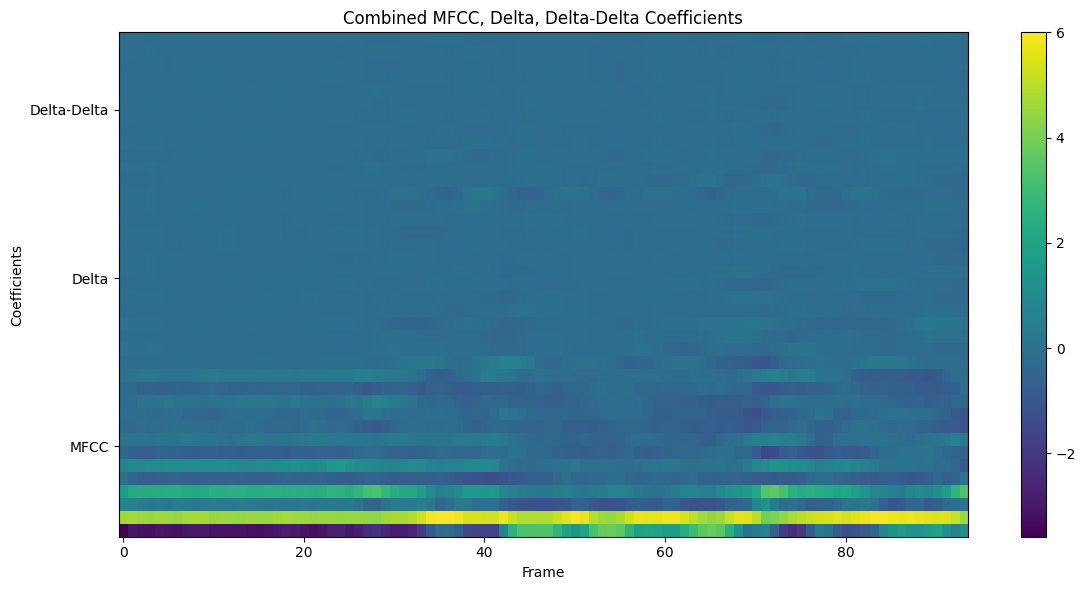

array([[-3.5860662 ,  4.6186833 ,  0.7580069 , ..., -0.15708554,
        -0.07992894, -0.12292159],
       [-2.9995348 ,  4.70082   ,  0.6652211 , ..., -0.19201908,
        -0.12353586, -0.16169558],
       [-3.0993543 ,  4.5626783 ,  0.426312  , ..., -0.17280622,
        -0.11171044, -0.14575379],
       ...,
       [ 1.257184  ,  5.557013  , -0.20900291, ..., -0.14491042,
        -0.13893206, -0.12467621],
       [ 0.735959  ,  5.1919026 , -0.0660508 , ..., -0.15941311,
        -0.15332213, -0.13879773],
       [ 1.1751672 ,  4.5792346 ,  0.0803216 , ..., -0.16099355,
        -0.1544345 , -0.13879398]], dtype=float32)

In [18]:
matrix, _ = train_dataset[1]
display_mfcc(matrix)
matrix

## Build the model

In [19]:
class CNNModel(nn.Module): # 94 by 39 matrix sizes
  def __init__(self, num_classes):
    super().__init__()
    self.model = nn.Sequential(
      # torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
      # stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        
        # what we had before
        nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Flatten(),

        nn.Linear(13248, 256),
        nn.ReLU(),

        nn.Linear(256, 128),
        nn.ReLU(),

        nn.Linear(128, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.model(x)
    return x

model = CNNModel(num_classes=audio_dataset.num_classes()).to(device)

In [20]:
model

CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=13248, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=8, bias=True)
    (14): Softmax(dim=1)
  )
)

## Training Functions

In [21]:
def save_checkpoint(lr, fold, epoch, model, optimizer, mode='checkpoint', extra_data=None):
  # This function will be used to create checkpoints along the learning (mode='checkpoint'), and also to save the last state
  # in each part of training (mode='last state'), so it can be restored and continue the training

  checkpoint = {
      'lr': lr,
      'fold': fold,
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'extras': extra_data,
  }
  
  if mode == 'checkpoint': filepath = f'./Checkpoints/checkpoint_lr_{lr}_fold_{fold}_epoch_{epoch}.pth'
  elif mode == 'last state':
    filepath = './Checkpoints/last_state.pth'

  if not(os.path.isdir("Checkpoints")): os.makedirs("Checkpoints", exist_ok=True)
  torch.save(checkpoint, filepath)

In [22]:
def load_checkpoint(model, optimizer, filepath):
  checkpoint = torch.load(filepath)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  lr = checkpoint['lr']
  fold = checkpoint['fold']
  epoch = checkpoint['epoch']
  extra_data = checkpoint['extras']
      
  return model, optimizer, lr, fold, epoch, extra_data

def load_last_lr():
    checkpoint = torch.load('./Checkpoints/last_state.pth')
    return checkpoint['lr']

In [23]:
def evaluate(model, val_loader):
    # Evaluate accuracy on validation dataset
    model.eval()
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
      for audios, labels in val_loader:
        audios = audios.unsqueeze(1)
        audios, labels = audios.to(device), labels.to(device)

        outputs = model(audios)
        outputs = outputs.to(device)
        _, predicted = torch.max(outputs, 1)

        total_correct_val += (predicted == labels).sum().item()
        total_samples_val += labels.size(0)

    accuracy_val = total_correct_val / total_samples_val
    print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")
    return accuracy_val

In [24]:
def train(num_epochs, lr, fold, optimizer, criterion, train_loader, val_loader, val_after_each_epoch=True):

  global model   # use the global model

  halfpoint = round(num_epochs/2)

  # For plotting after training
  loss_history = []
  train_accuracy_history = []
  val_accuracy_history = []
     
  epoch_passed = 0

  for epoch in range(num_epochs):      

    model.train()

    # Evaluating accuracy
    running_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0

    # print("start training")
    for inputs, labels in train_loader:
      # Start train
      inputs = inputs.unsqueeze(1)
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # End train

      total_correct_train += (predicted == labels).sum().item()
      total_samples_train += labels.size(0)

      running_loss += loss.item()
    # print("training finished")
    
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = total_correct_train / total_samples_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%')
    
    loss_history.append(epoch_loss)
    train_accuracy_history.append(accuracy_train)

    if epoch > halfpoint:
      save_checkpoint(lr, fold, epoch, model, optimizer)

    if val_after_each_epoch:
          val_accuracy_history.append(evaluate(model, val_loader))      
        
  return loss_history, train_accuracy_history, val_accuracy_history

In [25]:
# learning rates
lr_values = [0.0005, 0.001, 0.005, 0.01]

In [26]:
# Global Batch Size and Number of Folds
batch_size = 256     # Optimize the batch size here
k_folds = 4

## Grid Search

In [27]:
# Number of epochs
num_epochs = 25

In [28]:
def grid_search(num_epochs, lr_values, batch_size, k_folds):

  global model   # use the global model

  # print("running grid")
  criterion = nn.CrossEntropyLoss()
  all_loss_history = {}
  all_train_accuracy_history = {}
  all_val_accuracy_history = {}

  # check for any restore points in training process
  last_lr, last_fold, last_epoch = None, None, None
  if (os.path.isfile('./Checkpoints/last_state.pth')):
    print('Found a restore point!')
    optimizer = optim.Adam(model.parameters(), lr=load_last_lr())
    model, optimizer, last_lr, last_fold, last_epoch, histories = load_checkpoint(model, optimizer, './Checkpoints/last_state.pth')
    all_loss_history = histories['all_loss_history']
    all_train_accuracy_history = histories['all_train_accuracy_history']
    all_val_accuracy_history = histories['all_val_accuracy_history']
    print(f'Restore point info:\n  - learning rate: {last_lr},\n  - last fold: {last_fold+1},\n  - last epoch: {last_epoch}\n')

  for learn_rate in lr_values:
    print(f"-----LEARNING RATE: {learn_rate}-----")
    
    if (last_lr!=None and learn_rate!=last_lr): continue
    
    kf = KFold(n_splits=k_folds, shuffle=True)

    # Loop through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):      # the training dataset; includes validation

      if (last_fold!=None and fold<=last_fold): continue

      model = CNNModel(num_classes=audio_dataset.num_classes()).to(device)     # initiates a new model for each fold
      optimizer = optim.Adam(model.parameters(), lr=learn_rate)
      print(f"Fold {fold + 1}")
      print("-------")

      # Train/validation data loaders for current fold
      train_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(train_idx),
      )
      val_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(val_idx),
        )

      loss_history, train_accuracy_history, val_accuracy_history = train(num_epochs, learn_rate, fold, optimizer, criterion, train_loader, val_loader, val_after_each_epoch=True)

      try:
        all_loss_history[learn_rate].append(loss_history)
        all_train_accuracy_history[learn_rate].append(train_accuracy_history)
        all_val_accuracy_history[learn_rate].append(val_accuracy_history)
      except:
        all_loss_history[learn_rate] = [loss_history]
        all_train_accuracy_history[learn_rate] = [train_accuracy_history]
        all_val_accuracy_history[learn_rate] = [val_accuracy_history]
    
      # Save a restore point after the end of each fold
      histories = {
        'all_loss_history': all_loss_history,
        'all_train_accuracy_history': all_train_accuracy_history,
        'all_val_accuracy_history': all_val_accuracy_history,
      }
      save_checkpoint(learn_rate, fold, num_epochs, model, optimizer, mode='last state', extra_data=histories)
      print('saved restore point')

  return all_loss_history, all_train_accuracy_history, all_val_accuracy_history


## Training the Model

### Train the model using the Grid Search:

In [29]:
loss, train_acc, val_acc = grid_search(num_epochs=num_epochs, lr_values=lr_values, batch_size=batch_size, k_folds=k_folds) # Change later

-----LEARNING RATE: 0.0005-----
Fold 1
-------
Epoch [1/25], Loss: 2.0303, Training Accuracy: 20.63%
Validation Accuracy: 29.63%
Epoch [2/25], Loss: 1.9363, Training Accuracy: 33.22%
Validation Accuracy: 38.06%
Epoch [3/25], Loss: 1.8873, Training Accuracy: 38.56%
Validation Accuracy: 40.61%
Epoch [4/25], Loss: 1.8642, Training Accuracy: 40.06%
Validation Accuracy: 40.28%
Epoch [5/25], Loss: 1.8531, Training Accuracy: 41.57%
Validation Accuracy: 42.17%
Epoch [6/25], Loss: 1.8245, Training Accuracy: 44.26%
Validation Accuracy: 46.77%
Epoch [7/25], Loss: 1.7996, Training Accuracy: 47.12%
Validation Accuracy: 49.24%
Epoch [8/25], Loss: 1.7798, Training Accuracy: 49.23%
Validation Accuracy: 48.38%
Epoch [9/25], Loss: 1.7735, Training Accuracy: 49.88%
Validation Accuracy: 49.77%
Epoch [10/25], Loss: 1.7615, Training Accuracy: 50.82%
Validation Accuracy: 49.86%
Epoch [11/25], Loss: 1.7625, Training Accuracy: 50.86%
Validation Accuracy: 49.82%
Epoch [12/25], Loss: 1.7534, Training Accuracy: 5

In [58]:
print(loss)
print(train_acc)
print(val_acc)

{0.0005: [[2.0303425501132835, 1.936301876758707, 1.887285302425253, 1.8642016320393002, 1.8531098653530251, 1.8244842044238387, 1.799571727884227, 1.7798002053951394, 1.7734948191149482, 1.7615141169778232, 1.7624546988257046, 1.7534288496806705, 1.7429301039925937, 1.7324383710992748, 1.7299297143673074, 1.7319608269066646, 1.721083168325753, 1.7148940522095253, 1.7027112903266117, 1.7032193233226907, 1.6976757008453895, 1.6918775542029019, 1.688612308995477, 1.6777041122831147, 1.6748425796114166], [1.9993914242448478, 1.8910085373911365, 1.8583840625039463, 1.8467119808854728, 1.8360188788381115, 1.8222739203222866, 1.7996173233821475, 1.7863849771433864, 1.7720982494025395, 1.7653597881054055, 1.7499218726980275, 1.7534197198933568, 1.7416330740369599, 1.7357243916084026, 1.7385176255785186, 1.7223320212857476, 1.7158320320063625, 1.7064953302514965, 1.7066030954492504, 1.6957090558676884, 1.6916630761376743, 1.6910143556265995, 1.6766404201244485, 1.6677061607097756, 1.6705312235

#### Saving Grid search loss, training, and validation histories

In [59]:
# Saving all of the learning histories we gathered during the training
histories = {
'all_loss_history': loss,
'all_train_accuracy_history': train_acc,
'all_val_accuracy_history': val_acc,
}
filename = '/1_Grid_Search_lr_0.0005_0.001_0.005_0.01_4_folds_25_epochs_Complete_history.pkl'
with open(f'Results/{filename}', 'wb') as f:
    pickle.dump(histories, f)

In [60]:
# Load all the saved histories
filename = '/1_Grid_Search_lr_0.0005_0.001_0.005_0.01_4_folds_25_epochs_Complete_history.pkl'
with open(f'./Results/{filename}', 'rb') as f:
    loaded_histories = pickle.load(f)

print(loaded_histories)
print(loaded_histories['all_loss_history'][0.001][2][13])   # loaded_history['category'][lr][fold][epoch]

{'all_loss_history': {0.0005: [[2.0303425501132835, 1.936301876758707, 1.887285302425253, 1.8642016320393002, 1.8531098653530251, 1.8244842044238387, 1.799571727884227, 1.7798002053951394, 1.7734948191149482, 1.7615141169778232, 1.7624546988257046, 1.7534288496806705, 1.7429301039925937, 1.7324383710992748, 1.7299297143673074, 1.7319608269066646, 1.721083168325753, 1.7148940522095253, 1.7027112903266117, 1.7032193233226907, 1.6976757008453895, 1.6918775542029019, 1.688612308995477, 1.6777041122831147, 1.6748425796114166], [1.9993914242448478, 1.8910085373911365, 1.8583840625039463, 1.8467119808854728, 1.8360188788381115, 1.8222739203222866, 1.7996173233821475, 1.7863849771433864, 1.7720982494025395, 1.7653597881054055, 1.7499218726980275, 1.7534197198933568, 1.7416330740369599, 1.7357243916084026, 1.7385176255785186, 1.7223320212857476, 1.7158320320063625, 1.7064953302514965, 1.7066030954492504, 1.6957090558676884, 1.6916630761376743, 1.6910143556265995, 1.6766404201244485, 1.667706160

In [43]:
# Model we want to check

check_epoch = 23
check_fold = 3
check_lr = 0.001 
optimizer = optim.Adam(model.parameters(), lr=check_lr)

loaded_model, loaded_optimizer, start_epoch = load_checkpoint(model, optimizer,
    f'./Checkpoints/checkpoint_lr_{check_lr}_fold_{check_fold}_epoch_{check_epoch}.pth')

## Plot the Training Results

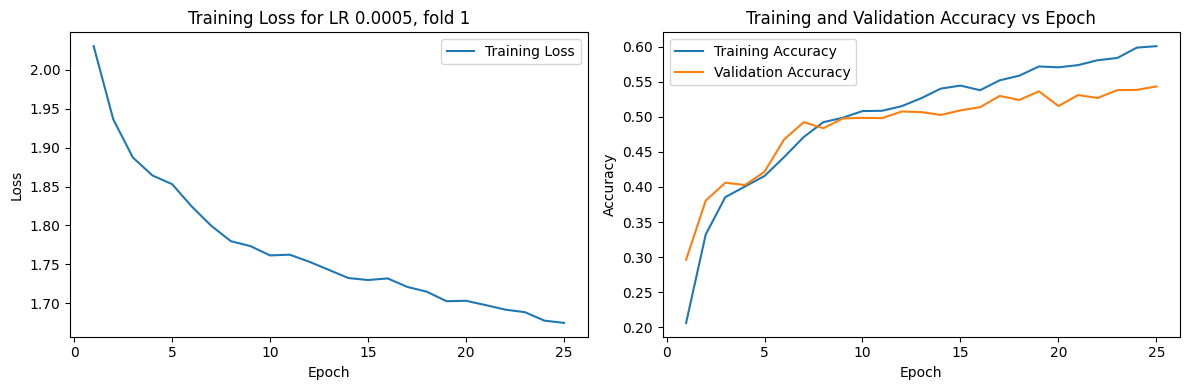

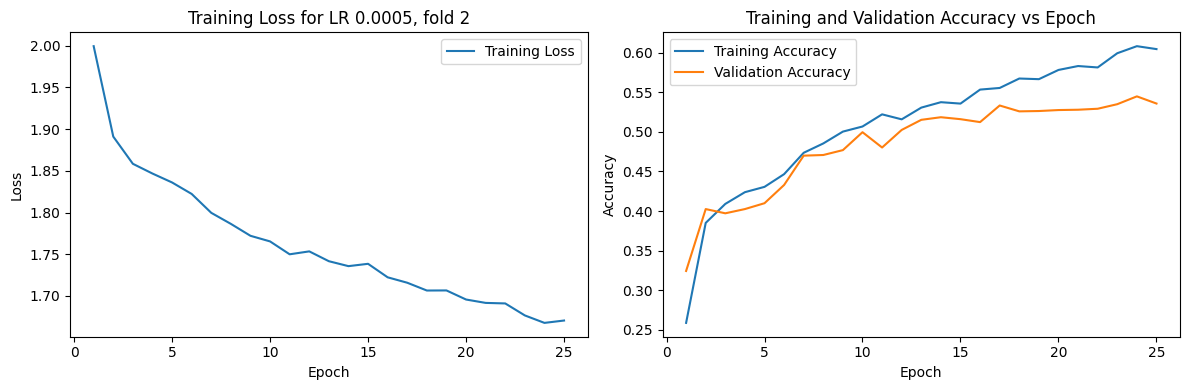

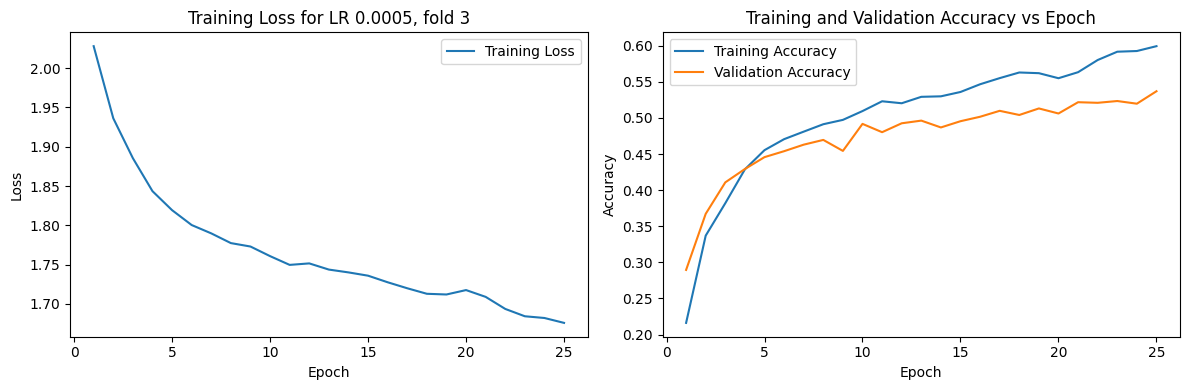

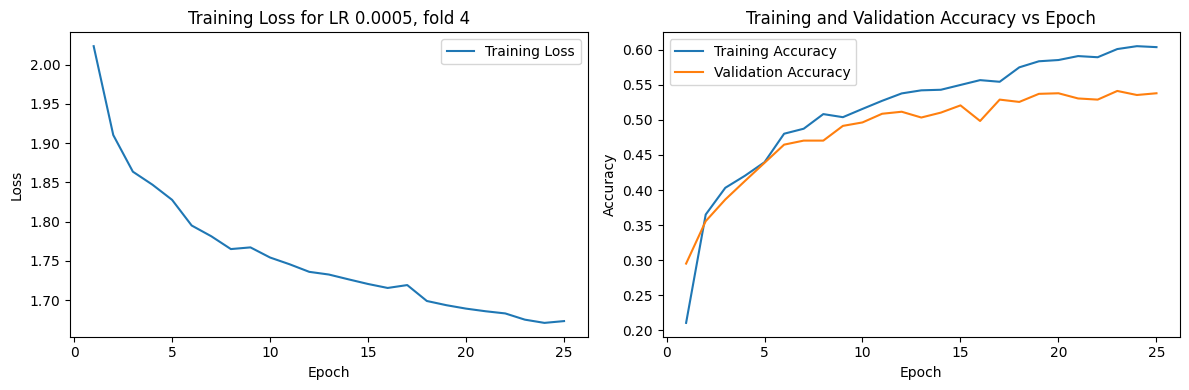

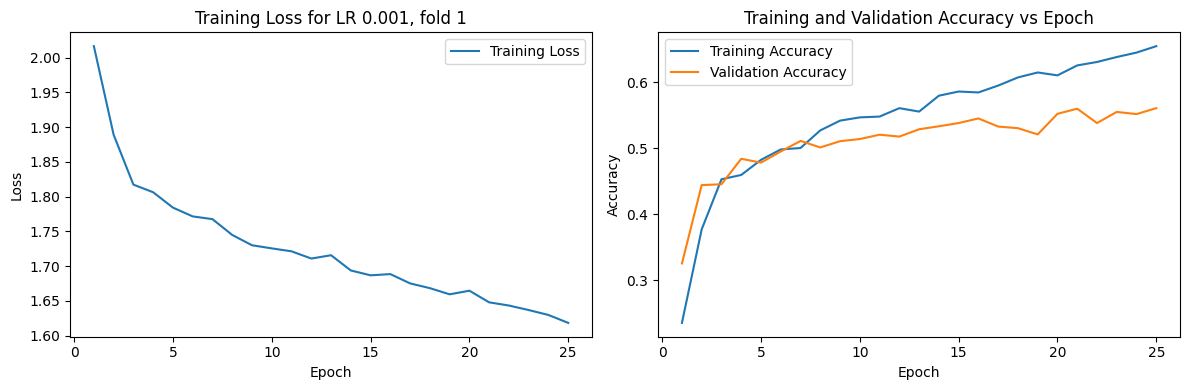

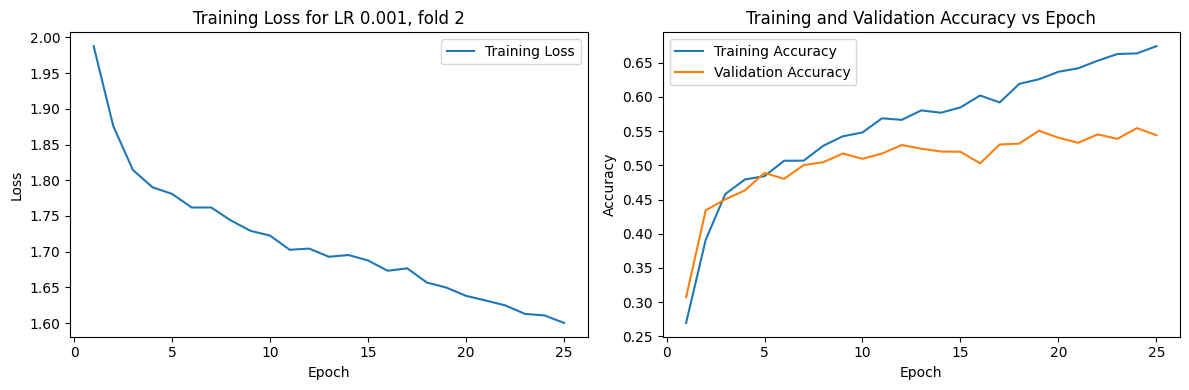

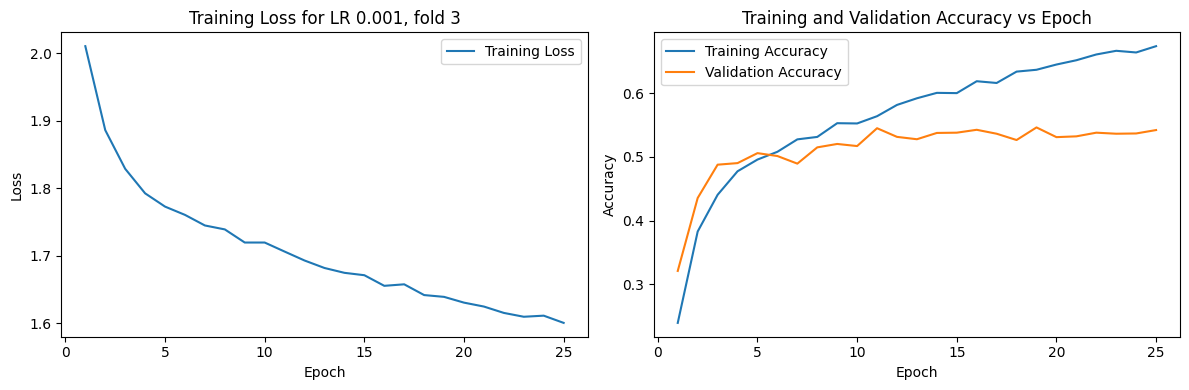

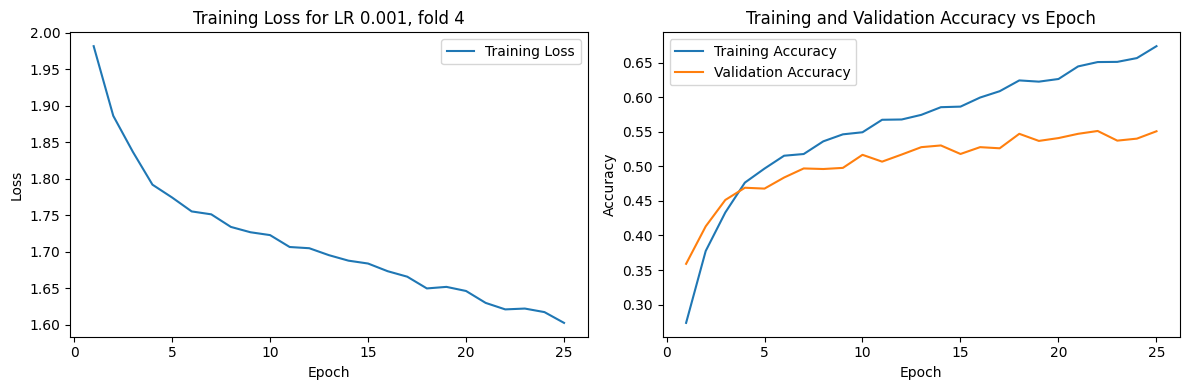

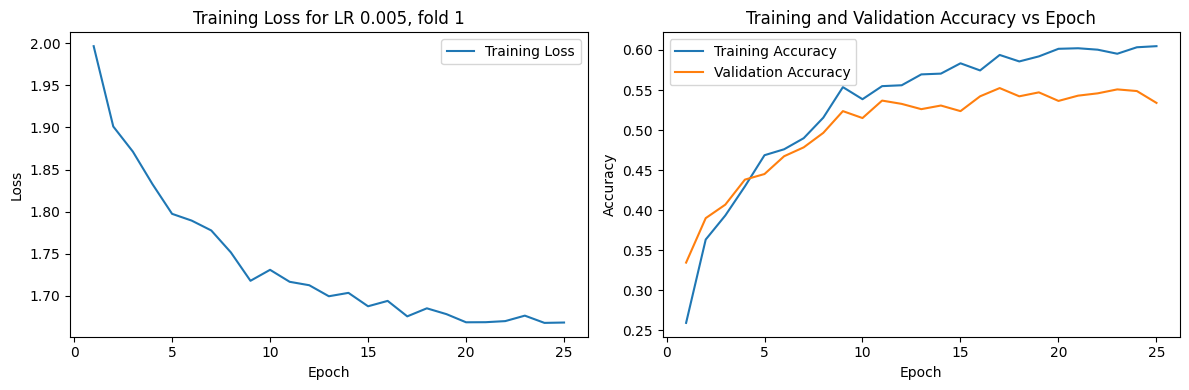

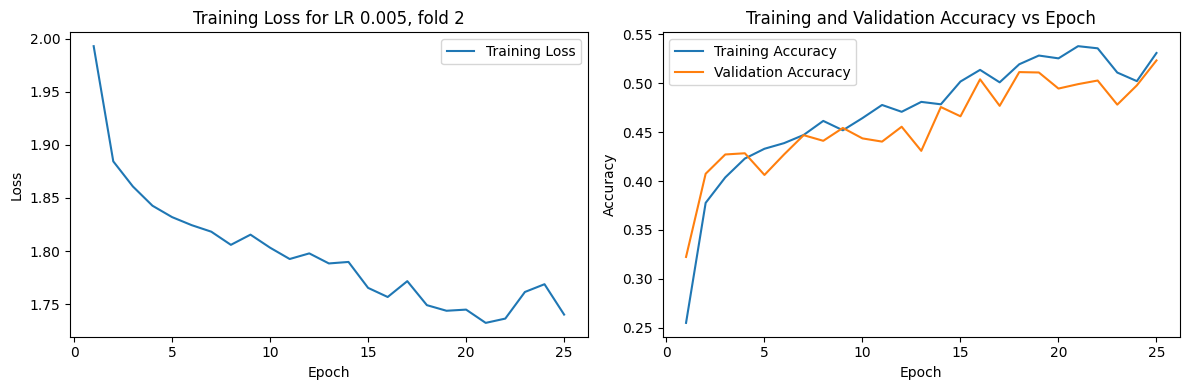

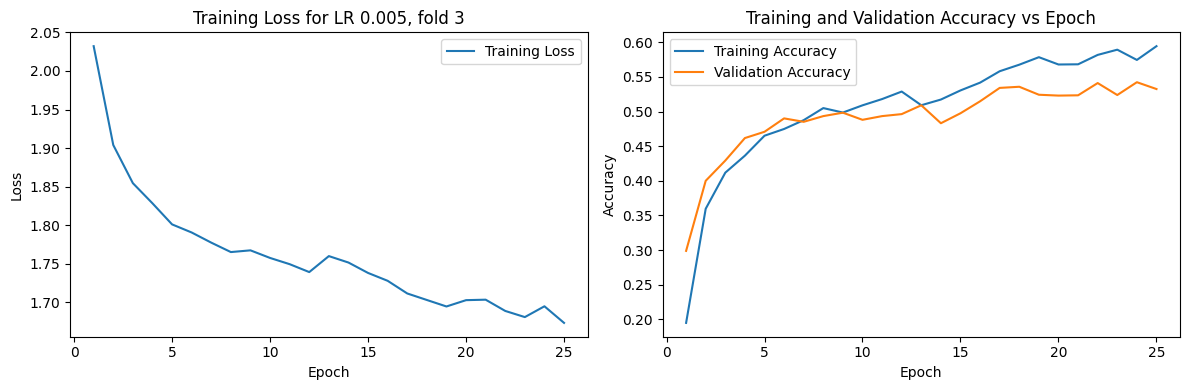

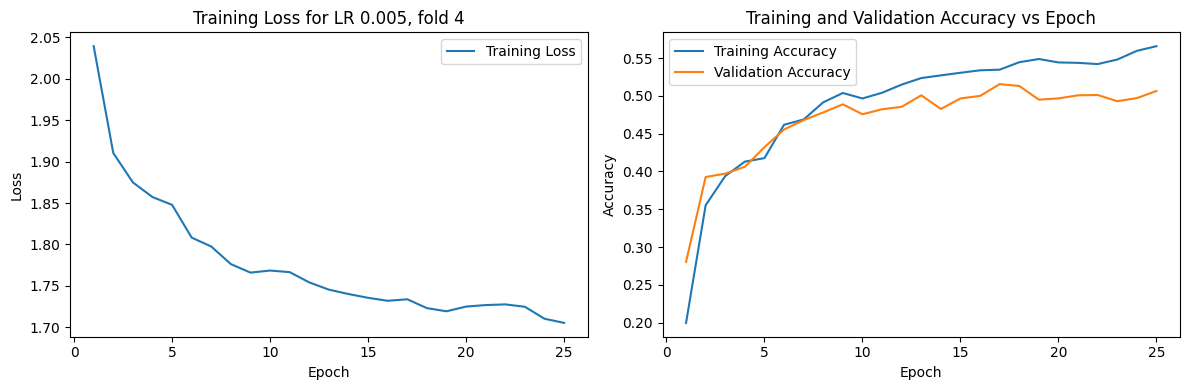

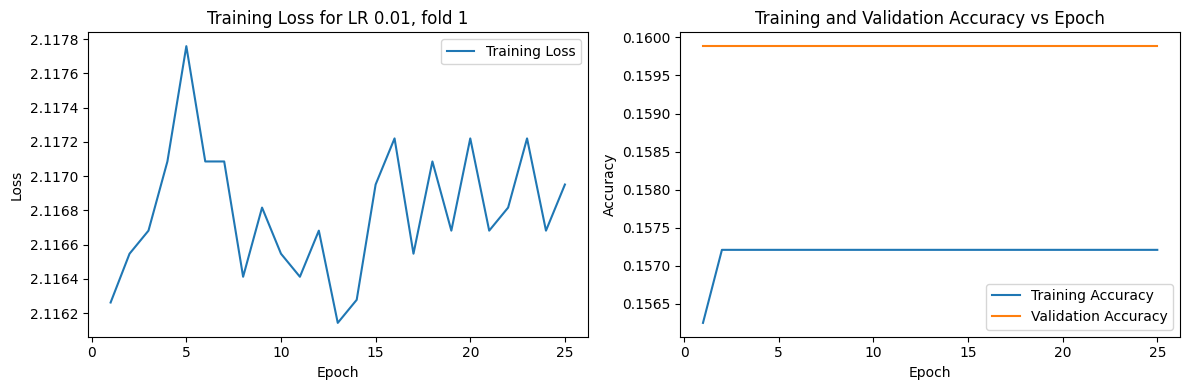

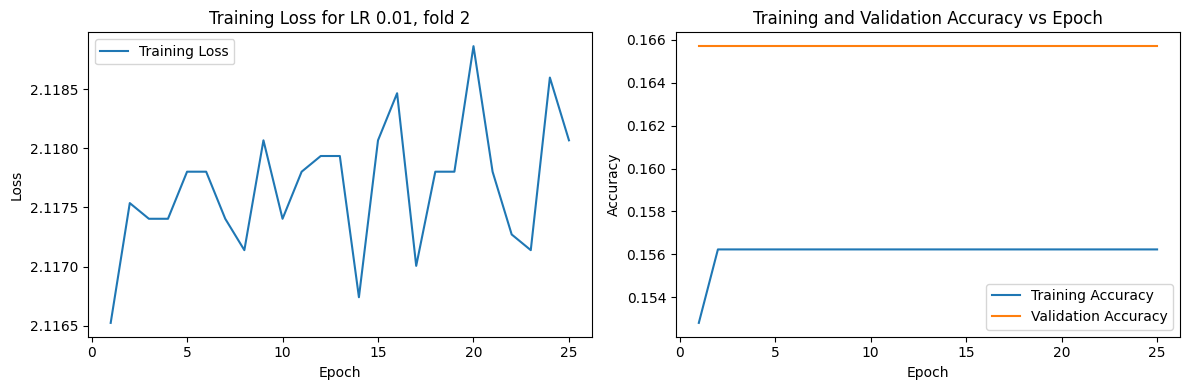

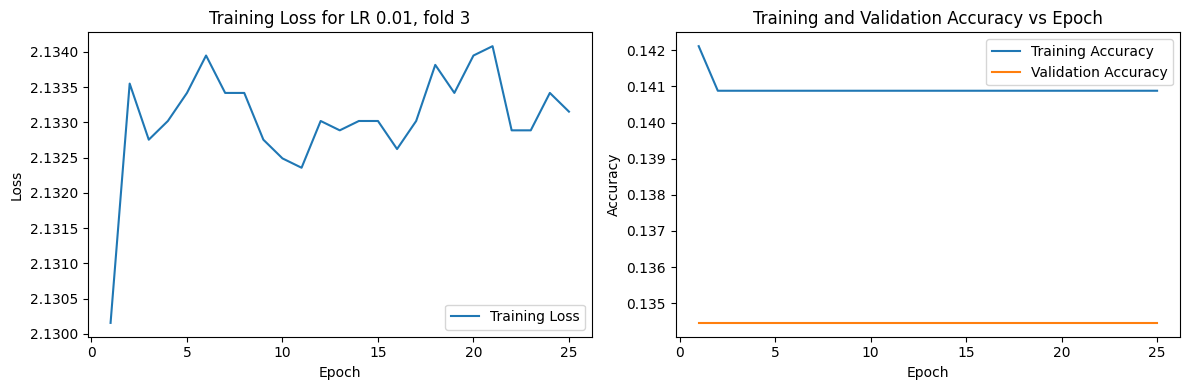

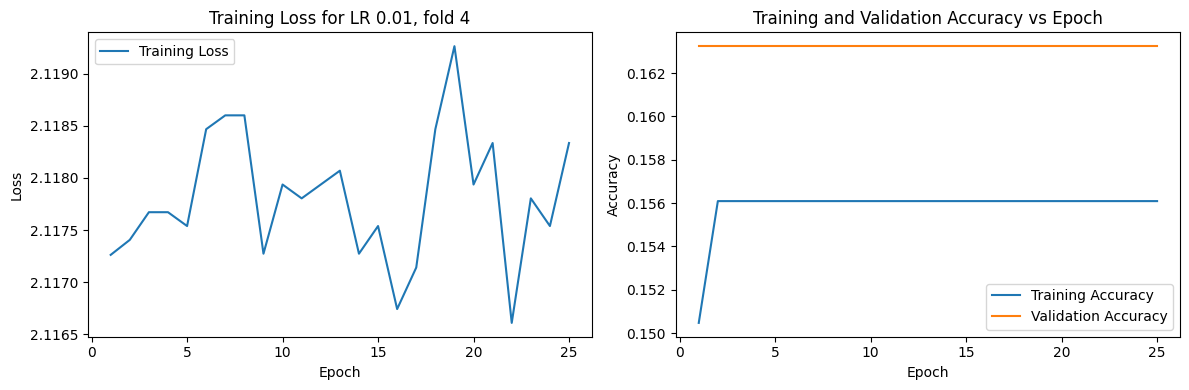

In [82]:
# Display plots for Grid Search results
for lr in lr_values:
    for fold in range(len(loss[lr])):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title(f'Training Loss for LR {lr}, fold {fold+1}')
        num_epochs_lr_fold = list(range(1, num_epochs + 1))  # Create a list of epochs for the current lr and fold
        plt.plot(num_epochs_lr_fold, loss[lr][fold], label='Training Loss')  # Use num_epochs_lr_fold instead of num_epochs
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Training and Validation Accuracy vs Epoch')
        plt.plot(num_epochs_lr_fold, train_acc[lr][fold], label='Training Accuracy')  # Use num_epochs_lr_fold instead of num_epochs
        plt.plot(num_epochs_lr_fold, val_acc[lr][fold], label='Validation Accuracy')  # Use num_epochs_lr_fold instead of num_epochs
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Saving the Weights

In [46]:
if not(os.path.isdir("ModelWeights")): os.makedirs("ModelWeights", exist_ok=True)
torch.save(model.state_dict(), './ModelWeights/trained_model.pth')

## Loading the Weights

In [21]:
model = CNNModel(num_classes=audio_dataset.num_classes()).to(device)
model.load_state_dict(torch.load('./ModelWeights/trained_model.pth', map_location=torch.device(device)))
model.eval()

CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=13248, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=8, bias=True)
    (14): Softmax(dim=1)
  )
)

## Test the model's results

In [179]:
from random import randint

# Select a random audio file from the dataset
audio_index = randint(0, len(audio_dataset)) # Change this to the index of the audio file you want to use
audio_file_path = audio_dataset.audio_files['path'][audio_index]
audio_file, audio_label = audio_dataset[audio_index]

# Load the audio file and extract MFCCs
audio_tensor = torch.tensor(audio_file, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# Pass the audio tensor through the model
model.eval()
with torch.no_grad():
    output = model(audio_tensor)

# Get the predicted label
predicted_label = torch.argmax(output).item()

# Print the results
print("Audio File:", audio_file_path)
print("True Label:", audio_label, Lib.convert_label(audio_label))
print("Predicted Label:", predicted_label, Lib.convert_label(predicted_label))


Audio File: Data\resampled\RAVDESS\RAVDESS_resampled_297_emotion_7.wav
True Label: 7 surprised
Predicted Label: 2 happy
